# Parallélisation de l'étude de relations d'échelles

La cellule ci-dessous permet de générer un grand nombre d'échantillons et de les étudier en parallèle pour gagner du temps.
La parallélisation est basée sur deux variables :

* `n_fits` est le nombre d'échantillons différents à générer ;

* `n_threads` est le nombre de coeurs à utiliser en parallèle, i.e. le nombre d'échantillons à gérer simultanément.
`n_threads` doit être inférieur au nombre de coeurs disponibles sur la machine.
Sur `nika2d` et `nika2e`, `n_threads=50` devrait être raisonnable.

Par exemple, pour `n_fits=5000` et `n_threads=50`, le code gèrera l'analyse par blocs de 50 échantillons traités en parallèle, ce qu'il devra faire 100 fois pour arriver à compléter les 5000.

In [1]:
import numpy as np
from astropy.table import Table
from chainconsumer import ChainConsumer
from joblib import Parallel, delayed
from fisc import Data
import cluster_catalog

n_fits = 8  # Nombre d'échantillons à générer
n_threads = 4 # Nombre de coeurs à utiliser, i.e. nombre de fits gérés en même temps

truth = {"alpha.YIZ": -0.19, "beta.YIZ": 1.79, "sigma.YIZ.0": 0.075}  # Relation d'échelle Planck
np.random.seed(123)

# 1.
t = Table.read("./catalog_universe_1e5.fits")
catalog = cluster_catalog.ClusterCatalog.from_table(t)

def process():
    """
    Fonction sélectionnant un sous-échantillon et réalisant l'ajustement de sa relation d'échelle.
    """
    

    # 2.
    catalog.to_observable(alpha=truth["alpha.YIZ"], beta=truth["beta.YIZ"], sigma=truth["sigma.YIZ.0"])
    catalog.measurement_errors(err_frac_Y=(0.1, 0.0), err_frac_M=(0.1, 0.0), corr=(0.8, 0.85))

    # 3.
    boxes = cluster_catalog.boxes_lpsz  # les boîtes du LPSZ sont déjà écrites
    new_catalog = catalog.select_from_boxes(boxes, [5 for _ in range(len(boxes))])  # 5 amas par boîte

    # 4.
    d = Data.from_table(
        new_catalog(),
        x_obs="log_M_tilde",
        y_obs="log_Y_tilde",
        x_err="err_log_M_tilde",
        y_err="err_log_Y_tilde",
        y_threshold=None, # voir Notes
        corr="corr",
    )

    try:
        chains = d.fit_lira(3, 25000)
        return d
    except Exception as e:  # Ne crashe pas si quelque chose se passe mal
        print(e)

all_d = Parallel(n_jobs=n_threads)(delayed(process)() for _ in range(n_fits))

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: rjags

R[write to console]: Loading required package: rjags

R[write to console]: Loading required package: rjags

R[write to console]: Loading required package: rjags

R[write to console]: Linked to JAGS 4.3.0

R[write to console]: Linked to JAGS 4.3.0

R[write to console]: Linked to JAGS 4.3.0

R[write to console]: Linked to JAGS 4.3.0

R[write to console]: Loaded modules: basemod,bugs

R[write to console]: Loaded modules: basemod,bugs

R[write to console]: Loaded modules: basemod,bugs

R[write to console]: Loaded modules: basemod,bugs

R[write to console]: module mix loaded

R[write to console]: module mix loaded

R[write to console]: module mix loaded

R[write to console]: module mix loaded



Selection: Could only take 3 clusters (instead of 5) with 1.4 < y < 2.2 and 0.7 < z < 0.9.
[1]Selection: Could only take 4 clusters (instead of 5) with 1.4 < y < 2.2 and 0.5 < z < 0.7.
Selection: Could only take 1 clusters (instead of 5) with 1.4 < y < 2.2 and 0.7 < z < 0.9.
[1]Selection: Could only take 2 clusters (instead of 5) with 1.4 < y < 2.2 and 0.7 < z < 0.9.
[1] Running: nsteps=25000, nmix=3 Running: nsteps=25000, nmix=3
 Running: nsteps=25000, nmix=3

Selection: Could only take 2 clusters (instead of 5) with 1.4 < y < 2.2 and 0.7 < z < 0.9.
[1] Running: nsteps=25000, nmix=3
[1][1] "No threshold detected"
 "No threshold detected"
[1] "No threshold detected"
[1] "No threshold detected"
  |**************************************************| 100%
  |***********************************               |  70%
Iterations = 6252:31251
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 25000 

1. Empirical mean and standard deviation for each variable,
   plus standard

`all_d` est une liste contenant les instances `fisc.data` associées à chaque échantillon.
Donc, on peut accéder aux chaînes de Markov de l'ajustement de la relation pour l'échantillon `i` avec `all_d[i].lira_chains`.

In [7]:
all_d[0].lira_chains

,alpha.YIZ,beta.YIZ,gamma.YIZ,delta.YIZ,sigma.YIZ.0,gamma.sigma.YIZ.Fz,gamma.sigma.YIZ.D,alpha.XIZ,beta.XIZ,gamma.XIZ,...,gamma.mu.Z.min.D,sigma.Z.min.0,gamma.sigma.Z.min.Fz,gamma.sigma.Z.min.D,pi.2.,mu.Z.0.mixture.2.,sigma.Z.0.mixture.2.,pi.3.,mu.Z.0.mixture.3.,sigma.Z.0.mixture.3.
1,-0.223736,1.856576,0.0,0.0,0.109270,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.007622,8514.492725,3.944924e+15,0.652499,-0.135495,0.013255
2,-0.222262,1.767530,0.0,0.0,0.093772,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.007622,6406.803138,7.281673e+15,0.652499,-0.133620,0.010845
3,-0.213284,1.801468,0.0,0.0,0.068160,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.007622,7370.674213,3.760068e+15,0.652499,-0.139019,0.011142
4,-0.209237,1.822094,0.0,0.0,0.086765,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.007622,5054.305701,2.640110e+15,0.652499,-0.142356,0.012516
5,-0.181723,1.638634,0.0,0.0,0.094700,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.007622,4184.390272,3.547357e+15,0.652499,-0.143767,0.013475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24996,-0.135123,1.744205,0.0,0.0,0.111776,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.002680,-4266.631975,3.497381e+05,0.714209,0.080182,0.077259
24997,-0.154880,1.479487,0.0,0.0,0.100788,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.002680,4728.413433,1.658388e+05,0.714209,0.084644,0.129429
24998,-0.159192,1.639009,0.0,0.0,0.110891,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.002680,-2716.824352,1.824800e+05,0.714209,0.091898,0.141696
24999,-0.145919,1.578697,0.0,0.0,0.090952,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.002680,745.418544,1.812724e+05,0.714209,0.084126,0.105791


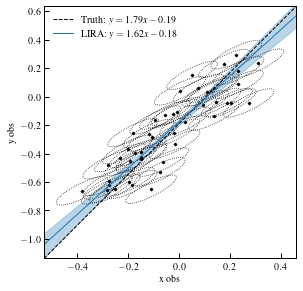

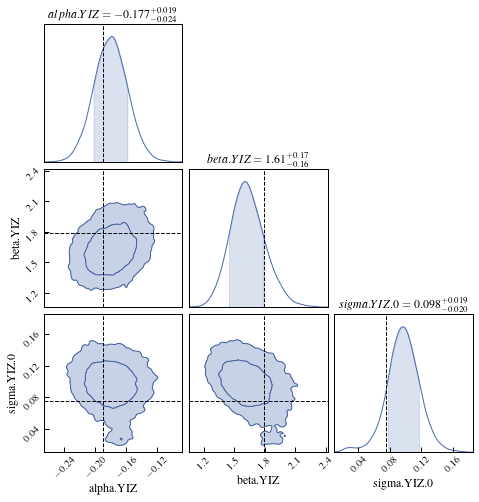

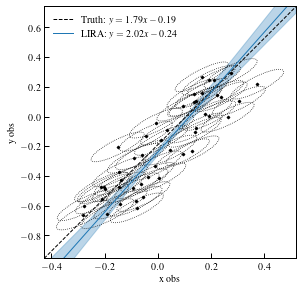

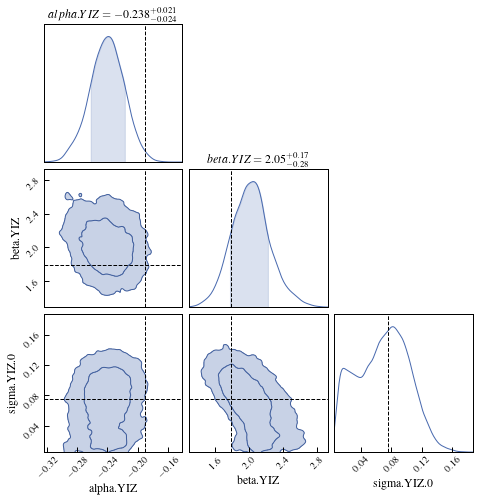

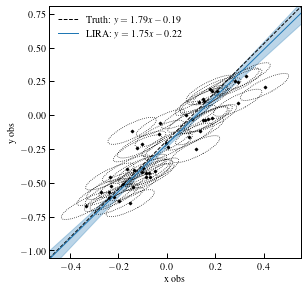

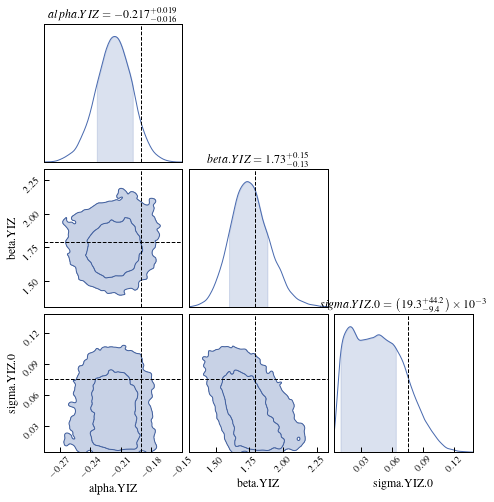

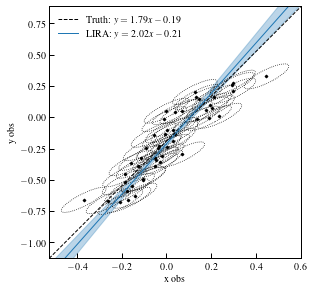

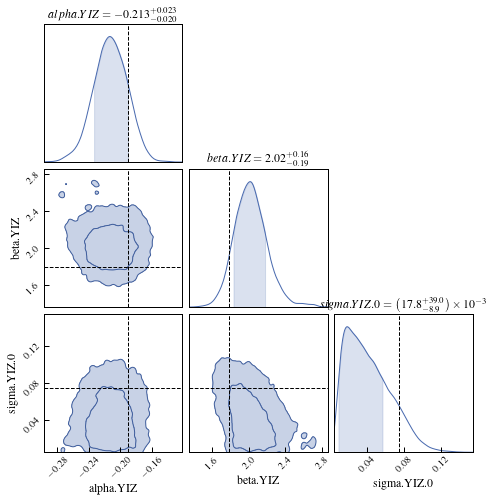

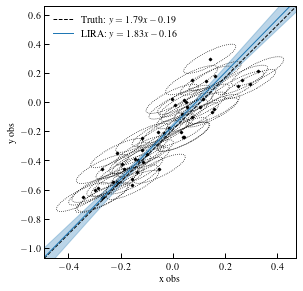

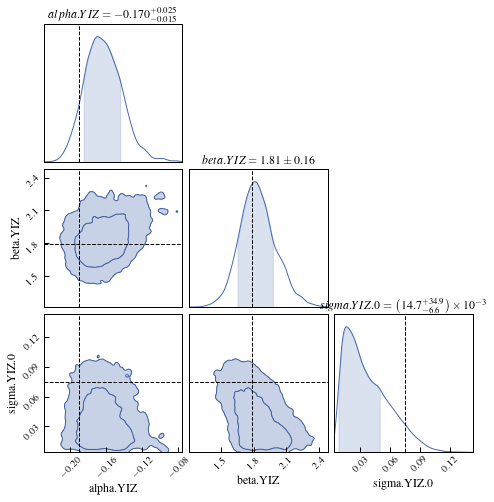

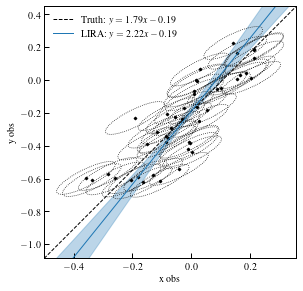

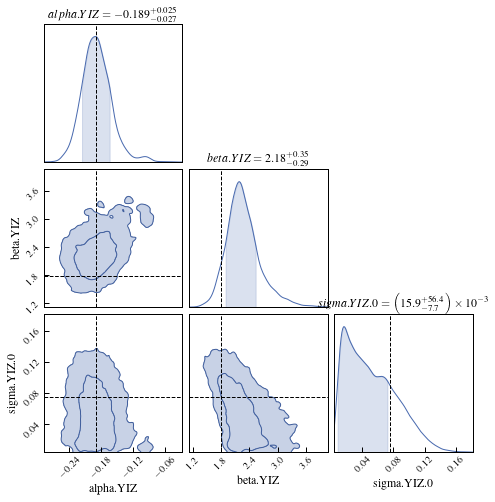

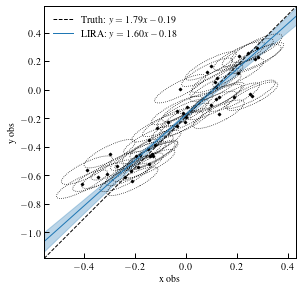

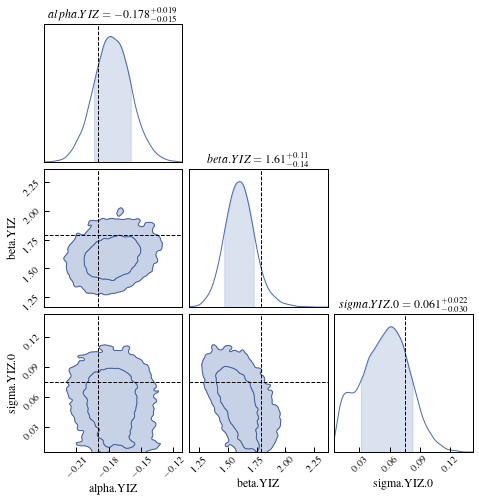

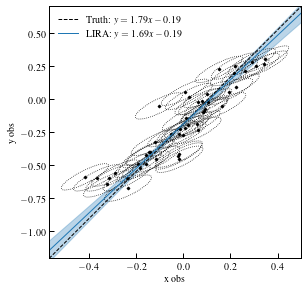

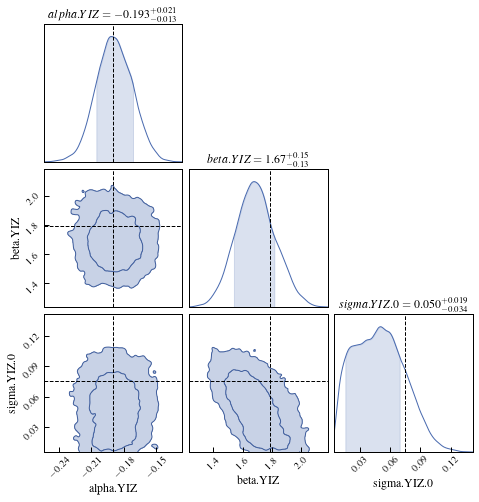

In [8]:
for d in all_d:  # Attention, très long si beaucoup d'échantillons !
    chains = d.lira_chains

    # Plot données / relation d'échelle réelle / relation d'échelle reconstruite
    fig, ax = d.plot_data(style="ellipse")
    d.plot_alphabeta(ax, truth["alpha.YIZ"], truth["beta.YIZ"], setlims=True, color="k", ls="--", label="Truth") # truth line
    d.plot_alphabeta(ax, np.median(chains["alpha.YIZ"]), np.median(chains["beta.YIZ"]), color="tab:blue", label="LIRA") # relation at median of chains
    d.plot_alphabeta(ax, chains["alpha.YIZ"], chains["beta.YIZ"], color="tab:blue") # chains confidence intervals
    ax.legend(frameon=False)

    # Corner plot distribution postérieure
    cc = ChainConsumer()
    cc.add_chain(chains[["alpha.YIZ", "beta.YIZ", "sigma.YIZ.0"]]) # only the 3 parameters of interest
    cc.configure(cmap="Spectral_r", shade_gradient=0.0, shade_alpha=0.3) # prettify!
    cfig = cc.plotter.plot(figsize=(7, 7), truth=truth)